### Markov Chains and Metropolis-Hastings Sampling

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import axes_grid1
from functools import partial

import numpy as np
from numpy.random import default_rng

plt.rcParams['figure.dpi'] = 200


def add_colorbar(im, ax, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)


seed = 9812631
rng = default_rng(seed)

#### Random Processes

A *random process* (or *stochastic process*) is an ordered sequence of random variables $X_1,X_2,\dots$.The most famous random process is the Wiener process (aka Brownian motion). A physical example is the motion of a body in a fluid. The small body is continually bumped by the fluid particles, giving it small, random impulses.

Writing the coordinates of the particle at time $t$ as $W_t$, the sequence $W_t$ is a random process. Formally,
the Wiener process starts with $W_0 = 0$. Each displacement $W_{t+u}-W_t$ is then an independent sample from a normal distribution with zero mean and variance $u$.

Here is a plot of a single realization of a 2D Wiener process with unit variance

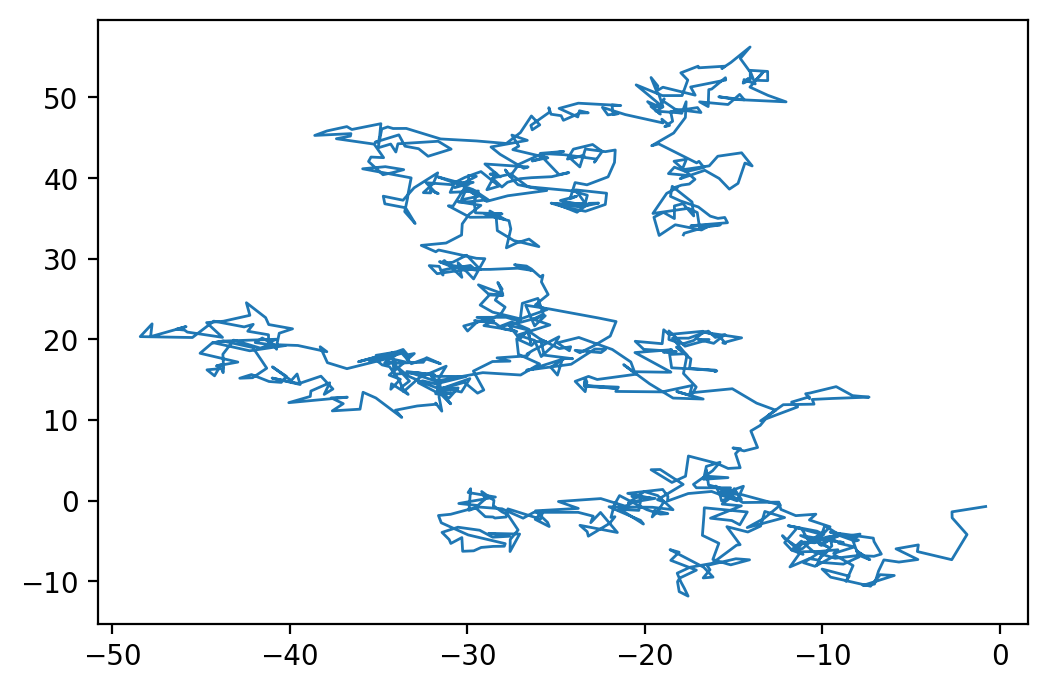

In [2]:
N = 1000
var = 1
dw = rng.multivariate_normal((0,0), np.eye(2)*var, N) # sequence of N impulses 
W = np.cumsum(dw, axis=0)                             # add them up

fig, ax = plt.subplots()
ax.plot(W[:,0], W[:,1], lw=1)

(Albert Einstein showed how Brownian motion is related to diffusion. In so doing, he was able to relate the number and size of the impulses to the diffusion coeffient. By measuring the diffusion coefficient, one is then able to infer a value for Avogadro's number.)

#### Markov Processes

Some definitions:

A *Markov Chain* is a random process:

> Let $D$ be a finite set. A random process $X_1, X_2,\dots$ with values in $D$ is a Markov Chain if
> $$\mathbb{P}\{X_{n+1}=x_{n+1}|X_n=x_n,\dots,X_0=x_0\} = \mathbb{P}\{X_{n+1} = x_{n+1} | X_n = x_n\} $$   

In other words, the state at time $n+1$ is dependent only upon the state at time $n$ and not on any earlier times.
One might say the process is "memoryless" or that "the future depends only upon the present, not the past".

A Markov chain can be definined by its transition probability matrix:

> The probability matrix $P = (p_{ij})_{i,j\in D}$

where the probability of making a transition from state $i$ to state $j$ is $p_{ij}$. Because $p_{ij}$ describes probabilities, each row of $P$ must sum to one.

A *time homogeneous* Markov chain is one in which the transition probabilities $P$ are constant
in "time."

A simple example: Let $D=\{r,s\}$ be the states "rainy" and "sunny". The random process $W_n$ is then a sequence of rainy and sunny days. Let $p$ be the probability that if today is rainy, tomorrow is sunny. Let $q$ be the probability that if today is sunny, tomorrow is rainy (near zero in Tucson!). Then the transition matrix for our
Markov weather process is
$$ P = \begin{bmatrix} 1-p & p \\ q & 1-q \end{bmatrix} $$

We can represent this as a graph:
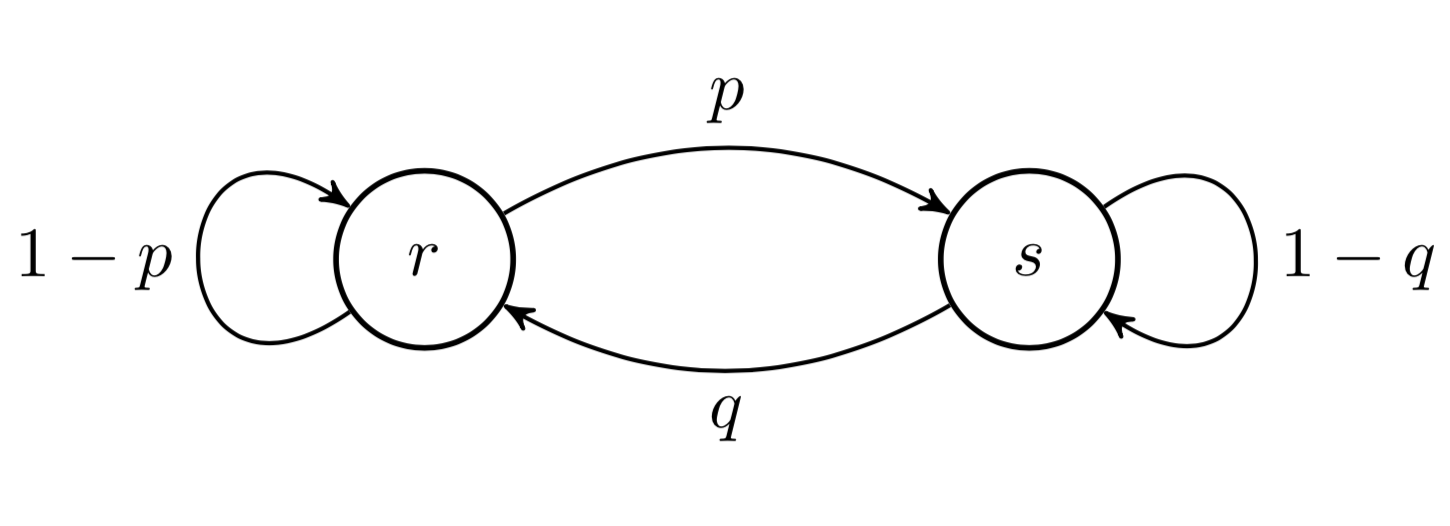

It is easy to determine the probability of any sequence described by a Markov chain. Let $D=\{a,b,c,d\}$. The probability of the path $b\rightarrow c \rightarrow a \rightarrow a \rightarrow d$ is then
$$ \mathbb{P}\{X_0=b, X_1=c, X_2=a, X_3=a, X_4=d\} = \mathbb{P}\{X_0=b\} p_{ba}p_{ca}p_{aa}p_{ad} $$

Since any state depends upon the beginning state, we'll define 
$$\mathbb{P}_a\{X_1=x_1\} = \mathbb{P}\{X_1=x_1|X_0=a\} $$
With this,
$$ \mathbb{P}_i\{X_n=j\} = \left(P^n\right)_{ij} $$
where the matrix power simply means repeated multiplication by the matrix.

For $n=2$ we have
\begin{align}
\mathbb{P}_i\{X_2=j\} &= \sum_{d\in D}\mathbb{P}_i\{X_2=j, X_1=d\} \\
&= \sum_{d\in D} \mathbb{P}\{X_2=j|X_1=d\} \mathbb{P}_i\{X_1=d\} \\
&= \sum_{d\in D} p_{id}p_{dj} \\
&= (P^2)_{ij}
\end{align}
and we see from the sum that the matrix multiplication *marginalizes* (sums) over all of the possible intermediate states.

We will be interested in a particular kind of Markov chain, one in which the average over time equals the average over space (the set $D$). Remembering our statistical mechanics, this is known as an *ergodic* system:

> A Markov chain is *ergodic* if the limit
> $$ \pi(j) = \lim_{n\rightarrow\infty} \mathbb{P}_i\{X_n=j\} = \lim_{n\rightarrow\infty} (P^n)_{ij}$$
> exists for every state $j$ and is independent of the starting state $i$.

The vector $\pi$ is called the stationary probability distribution of the Markov chain. This is easy to show; if the chain is ergodic, then
\begin{align}
\pi (j) &= \lim_{n\rightarrow\infty} (P^n)_{ij} \\
       &= \lim_{n\rightarrow\infty} (P^{n+1})_{ij} \\
       &= \lim_{n\rightarrow\infty} (P^n P)_{ij} \\
       &= \lim_{\rightarrow\infty} \sum_{d\in D}(P^n)_{id} P_{dj} \\
       &= \sum_{d\in D} \pi(d) P_{dj}
\end{align}

The Markov state is said to have *mixed* when the distribution no longer changes when multiplied by the transition matrix.

Clearly,
\begin{align}
\pi &= \pi P \\
(P^T-\mathbf{1}) \pi &= 0
\end{align}
is an eigenvalue problem; $(P^T-\mathbf{1})$ is thus a singular matrix. All of the rows of $P$ sum to one, so
$P$ has at least one eigenvalue equal to one, and the eigenvector $\pi$ is the equilibrium distribution of states.

If there is more than one eigenvalue equal to one, the limiting state will depend upon the starting state. This corresponds to a graph with more than one partition which can be reached from some starting states but from which the other partitions cannot be reached.

Another pathology is that the chain may have a limit cycle and not a fixed equilibrium state $\pi$. In both of these cases, the chain is not ergodic.

So far, we've been discussing discrete distributions. Let's extend this to continuous distributions. In place of a transition matrix, we have a transition kernel $P(x,A)$ where $x\in \mathbb{R}^d$ and $A\subset\mathbb{R}^d$. $P(x,A)$ is then the conditional probability of moving from $x$ to a point in the set $A$. Because $P$ is a probability, $P(x,\mathbb{R}^d) = 1$.

The stationary distribution becomes
$$ \pi(y)dy = \int_{\mathbb{R}^d} P(x, dy) \pi(x) dx $$
and the iteration analogous to repeated multiplications by the discrete transition matrix $P$ is
\begin{align}
P^{(1)}(x,A) &= P(x,A)\\
P^{(n)}(x, A) &= \int_{\mathbb{R}^d} P^{(n-1)}(x,dy) P(y, A)
\end{align}
so that the stationary distribution becomes
$$ \pi(A) = \lim_{n\rightarrow\infty} P^{(n)}(x, A) $$ 

#### Markov Chain Monte Carlo: the Metropolis-Hastings Algorithm

In the 1950's at Los Alamos, Marshall and Arianna Rosenbluth invented a clever way to sample from certain probability distributions based on these ideas (N. Metropolis, A.W. Rosenbluth, M.N. Rosenbluth, A.H. Teller, & E. Teller 1953, "Equation of State Calculations by Fast Computing Machines", J. Chem. Phys. 21, 1087). It was generalized in 1970 by W. K. Hastings to sample from *any* probability distribution and is now known as the Metropolis-Hastings algorithm.

The original use was to sample states in a quantum-mechanical system and then compute averages over those states.
Metropolis described the method as: "Instead of choosing configurations randomly, then weighting them with exp(−E/kT), we choose configurations with a probability exp(−E/kT) and weight them evenly."

More generally, we want to sample from a probability distribution $\pi$. If we knew the transition kernel which in the limit above leads to a stationary (equilibrium) state, we could then generate samples from $\pi$ using the Markov chain iteration we have just described. We pick an arbitrary initial state, start iterating, wait for the Markov chain to mix (for the distribution generated to settle down to $\pi$), and then subsequent iterations would genereate samples from $\pi$.

The problem, of course, is that given some arbitrary $\pi$, there is no obvious way to find the kernel $P$. The MH algorithm is a clever way around this problem.

Write the kernel $P(x,dy)$ as
$$ P(x,dy) = \left\{\begin{array}\ r(x), & x\in dy\\ p(x,y) dy, & x \notin dy \end{array} \right. $$
where the $r(x)$ is the probability that the chain stays at $x$
$$ r(x) = 1 - \int_{\mathbb{R}^d} p(x,y) dy $$
and $p(x,y)$ is the probability of moving to some other state $y$. 

Since the authors of the algorithm were physicists, the idea of detailed balance would have been obvious to them from statistical mechanics:
$$ \pi(x) p(x,y) = \pi(y) p(y,x) $$
It is of course a consequence of $\pi$ as a stationary distribution (and is why we removed $r(x)$ from the definition of $p(x,y)$).

The role of detailed balance is as follows. Define $\mathbf{1}(x)$ as the indicator function, $=1$ when its argument is true, and $=0$ when it is not.
The we can write
\begin{align}
\int_{\mathbb{R}^d} P(x, A) \pi(x) dx
&= \int_{\mathbb{R}^d} \left[\int_A p(x, y) \mathbf{1}(x \notin dy) dy + r(x) \mathbf{1}(x \in dy) \right] \pi(x) dx
\\
&= \int_{\mathbb{R}^d} \left[\int_A p(x, y) \mathbf{1}(x \notin dy) dy \right] \pi(x) dx + \int_{\mathbb{R}^d} r(x) \mathbf{1}(x \in A) \pi(x) dx
\\
&= \int_{\mathbb{R}^d} \left[\int_A p(x, y) \mathbf{1}(x \notin dy) dy \right] \pi(x) dx + \int_A r(x) \pi(x) dx
\\
&= \int_A \left[\int_{\mathbb{R}^d} p(x, y) \pi(y) dx \right] \mathbf{1}(x \notin dy) dy  + \int_A r(x) \pi(x) dx
\end{align}
Now invoke detailed balance to let $p(x,y)\pi(y)=p(y,x)\pi(x)$
\begin{align}
\int_{\mathbb{R}^d} P(x, A) \pi(x) dx &= \int_A \left[\int_{\mathbb{R}^d} p(y, x) \pi(x) dx \right] \mathbf{1}(x \notin dy) dy  + \int_A r(x) \pi(x) dx \\
&= \int_A (1 - r(y)) \pi(y) dy + \int_A r(x) \pi(x) dx
\\
&= \int_A \pi(x) dx.
\end{align}

The key to finding the kernel $P(x,A)$ associated with $\pi$ is to ensure the reversability of $p(x,y)$.

We now take an approach similar to acceptance-rejection sampling. In that method, to sample from some pdf $p(x)$ we used a *covering function* $f(x)$ such that $f(x)>p(x), \forall x$. We sampled a uniform deviate $\xi_1$, and used the cumuative distribution $F(x) = \int_{\infty}^x f(t)dt$ to propose a sample $x= F^{-1}(\xi_1)$. The sample was then accepted if $\xi_1 < p(x)/f(x)$.

Metropolis-Hastings posits a function $q(y|x)$ which proposes a sample $y$ conditioned on $x$ which can be accepted or rejected according to some prescription. $q(y|x)$ is a pdf, so that $\int q(y|x) dy = 1$. If we got lucky and
picked a $q$ which satisfied detailed balance for our distribution $\pi(x)$
$$ q(y|x)\pi(x) = q(x|y)\pi(y) $$
we would be all set, but we don't know what $q$ to pick.

Instead, imagine that
$$ q(y|x) \pi(y) \ge q(x|y) \pi(x) $$
The chain would move from $y$ to $x$ more often than from $x$ to $y$. MH deals with this by rejection; define the function $\alpha(x,y)$ as a factor less than one which restores detailed balance
$$ \alpha(x,y) q(y|x) \pi(x)  = q(x|y) \pi(y) $$
This "acceptance function" is then
$$ \alpha(x,y) = \frac{q(x|y)\pi(y)}{q(y|x)\pi(x)} $$
If instead $q(y|x)$ moved from $y$ to $x$ *less* often than from $x$ to $y$, then $\alpha$ would be greater than one,
but we can handle both cases by writing
$$ \alpha(x,y) = \min\left(1, \frac{q(x|y)\pi(y)}{q(y|x)\pi(x)}\right) $$

Now, if $x$ moves to $y$ more often than the reverse, the probability of acceptance is reduced; if $x$ moves to $y$ less often, the move $x\rightarrow y$ is accepted with probability one.

This, then, is our unknown function
$$ p(x,y) = \alpha(x,y) q(y|x) $$
We still don't know the function explicitly, but we don't need to; acceptance/rejection will take care of making 
any $q(y|x)$ behave appropriately.

If $q$ is symmetric, $q(y|x) = q(x|y)$, and it cancels in the definition of $\alpha(x,y)$. We are left with
$$ \alpha(x,y) = \min\left(1, \frac{\pi(y)}{\pi(x)}\right) $$
This is the original 1953 algorithm. Hasting's contribution was allowing for an unsymmetric function $q(y|x)$.

Note that we don't even need to know the normalization of $\pi$ since it appears in both the numerator and the denominator. This will be important when we apply MCMC to problems in statistics.

The Metropolis algorithm for sampling from $p(x)$ is then
1. Begin with some arbitrary initial state $x_i = x_0$.
2. Propose some next state $x_{i+1} = x_i + dx$ by drawing an increment $dx$ from some distribution $f$
3. If
   $$ \alpha = \min\left(1, \frac{\pi(x_{i+1})}{\pi(x_i)}\right) $$
   is less than a uniform random deviate $\xi$, accept the new state. If not, the new state is the same as
   the previous state.
4. Repeat from 2. until a sufficient number of samples has been computed.

There is some art to this process. Just as for rejection sampling, if we choose a bad $f$, virtually all of our samples will be rejected.

Remember, we need to wait for the chain to mix, otherwise $\pi(x)$ is not (yet) a stationary distribution. This is known as "warmup" or "burn in" (from the term used to run electronics for a while to make sure it doesn't fail at the factory).

Let's use this to sample from a blackbody spectrum, the Planck pdf
$$ p(x) = \frac{15}{\pi^4}\frac{x^3}{e^x-1} $$

We'll draw our increment from a normal distribution of zero mean and variance $=\frac{1}{2}$ (the function $f$ above).

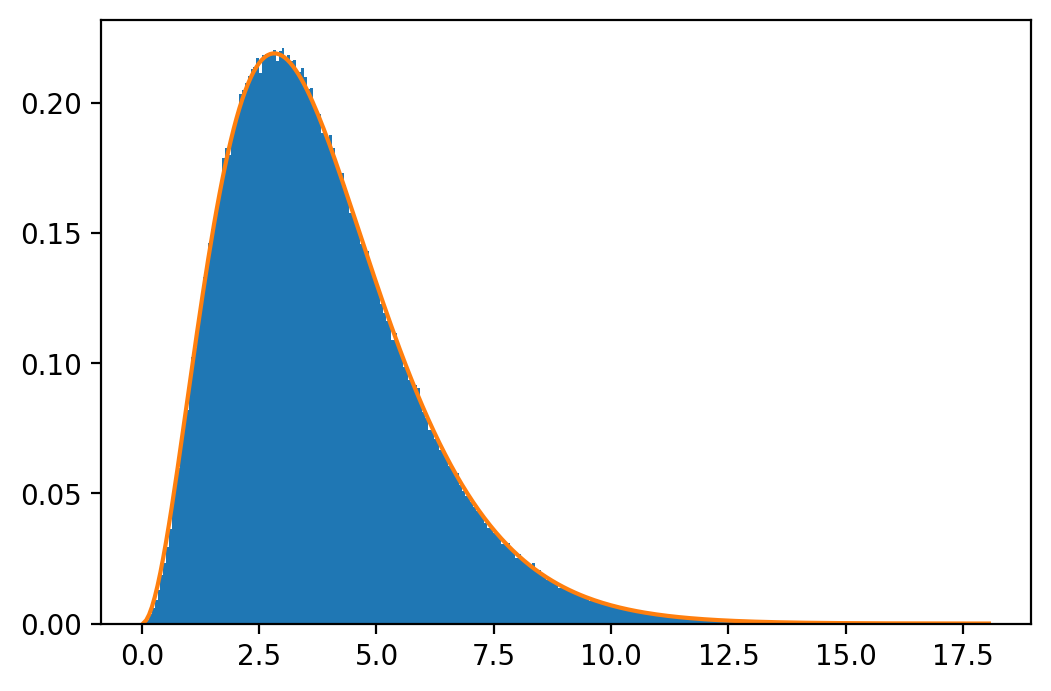

In [3]:
def planck(x):
    return 15*x**3*np.exp(-x)/(1-np.exp(-x))/np.pi**4

def sampleMH(func, xinit, N):
    x = np.zeros(N)
    x[0]=xinit
    for i in range(1,N):
        x[i] = x[i-1] + 0.5*rng.standard_normal()     # restrict sampling to the domain [0,infinity)
        while x[i] <= 0:
            x[i] = x[i-1] + 0.5*rng.standard_normal()
            
        alpha = min( 1, func(x[i])/func(x[i-1]))
        if rng.uniform() > alpha: # reject and set new sample to last sample
            x[i] = x[i-1]

    return x
            
N_warm = 10**1
N_samples = 10**6
x = sampleMH(planck, 0.001, N_warm)
x = sampleMH(planck, x[-1], N_samples)

fig,ax = plt.subplots()
tmp, bins, tmp = ax.hist(x, bins=300, density=True)
ax.plot(bins, planck(bins));

<hr style="border:2px solid gray"> </hr>

The Metropolis-Hastings algorithm really comes into its own when sampling from multidimensional distributions,
especially in a large number of dimensions where $\pi$ is large in a region which is difficult to describe *a priori*.

Let's try a standard 2D test problem, the Rosenbrock density
$$ \rho(x,y; a, b) = \exp\left\{-\frac{(a-x_1)^2 + b(x_2-x_1^2)^2}{20}\right\} $$
Note that this is not normalized, so not a pdf. Since $p(x)$ only enters the MH algorithm as the
ratio $p(x_{n+1})/p(x_n)$, this doesn't matter!

The density is a long, curving ridge with a maximum at $(x,y) = (a,a^2)$:

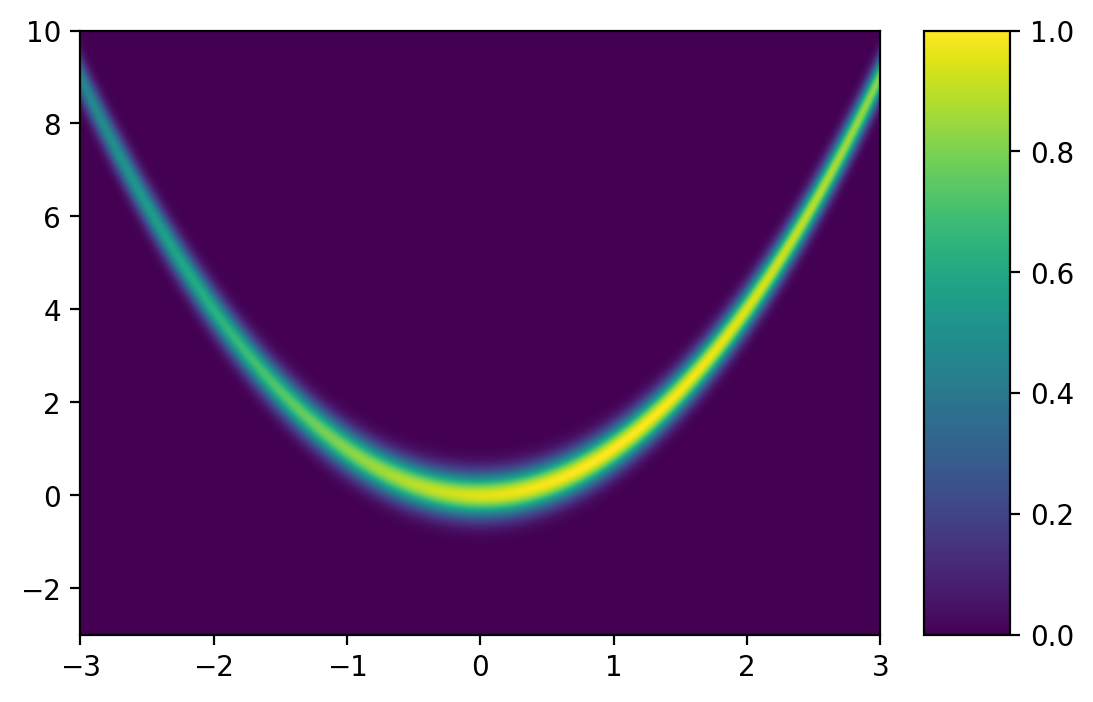

In [4]:
def rosen(x,y,a,b):
    return np.exp(-((a-x)**2+b*(y-x**2)**2)/20)

a, b = 1, 100
xmin,xmax = -3,3
ymin,ymax = -3,10
x1d = np.linspace(xmin,xmax, 1000)
y1d = np.linspace(ymin,ymax, 1000)
X,Y = np.meshgrid(x1d, y1d)
rho = rosen(X,Y,a,b)

fig,ax = plt.subplots()
im = ax.imshow(rho, vmin=0, vmax=1, extent=(xmin,xmax,ymin,ymax), origin='lower')
ax.set_aspect('auto')
add_colorbar(im,ax);

Now let's try running some Markov chains starting with a few different initial conditions. One can see the need for 
warmup...

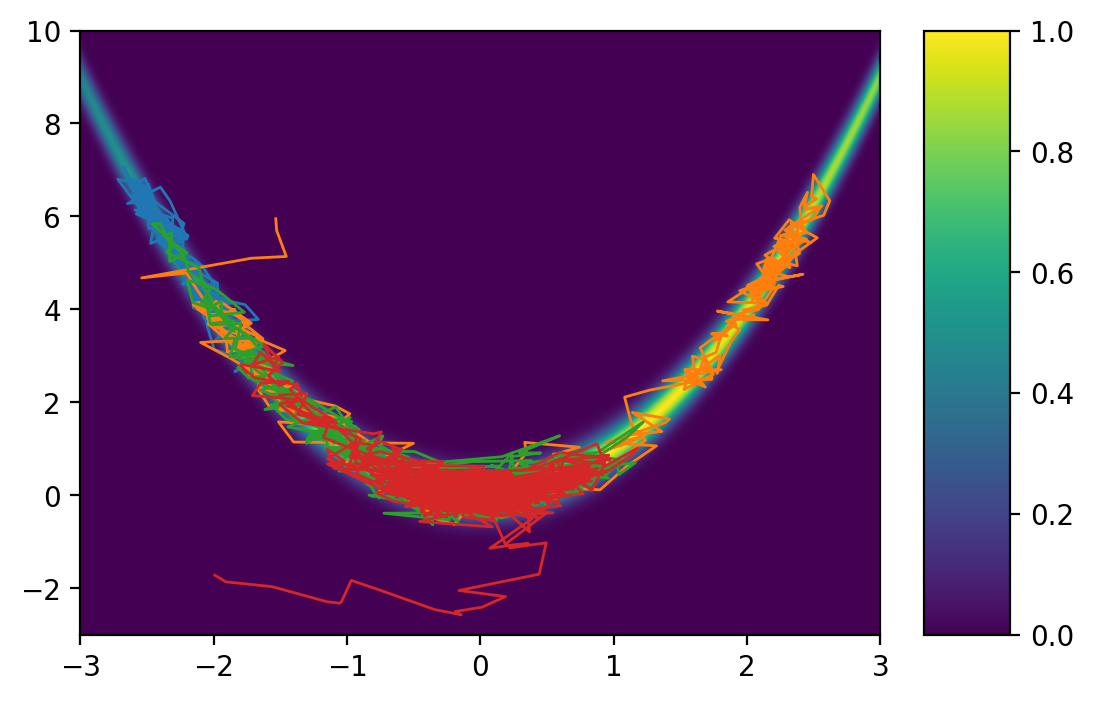

In [5]:
def rosenVec(xy,a,b):
    return np.exp(-((a-xy[0])**2+b*(xy[1]-xy[0]**2)**2)/20)

func = partial(rosenVec, a=a, b=b)

def sampleMH2(func, xinit, var, N):
    x = np.zeros((N,2))
    x[0,:]=xinit
    for i in range(1,N):
        x[i] = x[i-1] + rng.multivariate_normal((0,0), np.eye(2)*var)
        alpha = min( 1, func(x[i])/func(x[i-1]))
        if rng.uniform() > alpha: # reject
            x[i] = x[i-1]

    return x

N = 1000
lo = np.array([xmin, ymin])
hi = np.array([xmax, ymax])

fig,ax = plt.subplots()
im = ax.imshow(rho, vmin=0, vmax=1, extent=(xmin,xmax,ymin,ymax), origin='lower')
ax.set_aspect('auto')
add_colorbar(im,ax)

for i in range(4):
    init = (hi-lo)**rng.uniform(size=2) + lo
    x = sampleMH2(func, init, 0.1, N)
    ax.plot(x[:,0],x[:,1],lw=1)

This time, we will warm up for $100$ steps, and then run for $10^6$. As the Markov chain explores the density,
we'll look for the global maximum of the function. The process spends time proportional to the magnitude of the density, so this is a reasonably efficient way of looking for a global maximum.

maximum found at: rosen(1.0044868166388476,1.0096099306846802) = 0.999997095126062


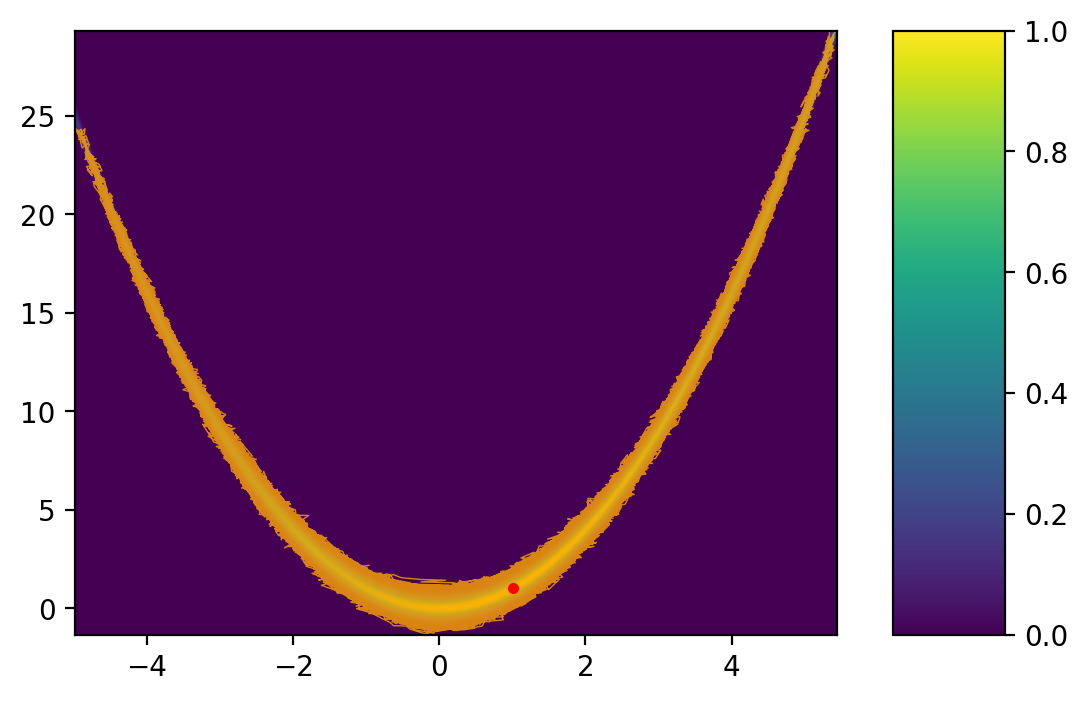

In [6]:
def rosenVec(xy,a,b):
    return np.exp(-((a-xy[0])**2+b*(xy[1]-xy[0]**2)**2)/20)

func = partial(rosenVec, a=a, b=b)

def sampleMH2(func, xinit, var, N):
    x = np.zeros((N,2))
    x[0,:]=xinit
    for i in range(1,N):
        x[i] = x[i-1] + rng.multivariate_normal((0,0), np.eye(2)*var)
        alpha = min( 1, func(x[i])/func(x[i-1]) )
        if rng.uniform() > alpha: # reject
            x[i] = x[i-1]

    return x

lo = np.array([xmin, ymin])
hi = np.array([xmax, ymax])

init = (0,0)
N_warmup = 10**2
N_sample = 10**6

x = sampleMH2(func, init, 0.1, N_warmup)
x = sampleMH2(func, x[-1], 0.1, N_sample)

fig,ax = plt.subplots()
# plot the function over the whole range explored by the Markov chain
xmin, xmax = np.min(x[:,0]), np.max(x[:,0])
ymin, ymax = np.min(x[:,1]), np.max(x[:,1])
x1d = np.linspace(xmin,xmax, 1000)
y1d = np.linspace(ymin,ymax, 1000)
X,Y = np.meshgrid(x1d, y1d)
rho = rosen(X,Y,1,100)

im = ax.imshow(rho, vmin=0, vmax=1, extent=(xmin,xmax,ymin,ymax), origin='lower')
ax.set_aspect('auto')
add_colorbar(im,ax)

# plot the realization of the Markov process
ax.plot(x[:,0],x[:,1],'orange',lw=0.5, alpha=0.8)

# find the maximum point visited
y = rosen(x[:,0],x[:,1],1,100)
i = np.argmax(y)
print(f"maximum found at: rosen({x[i,0]},{x[i,1]}) = {func(x[i])}")
ax.plot(x[i,0], x[i,1],'r.');

We can plot the density of points visited by the Markov chain:

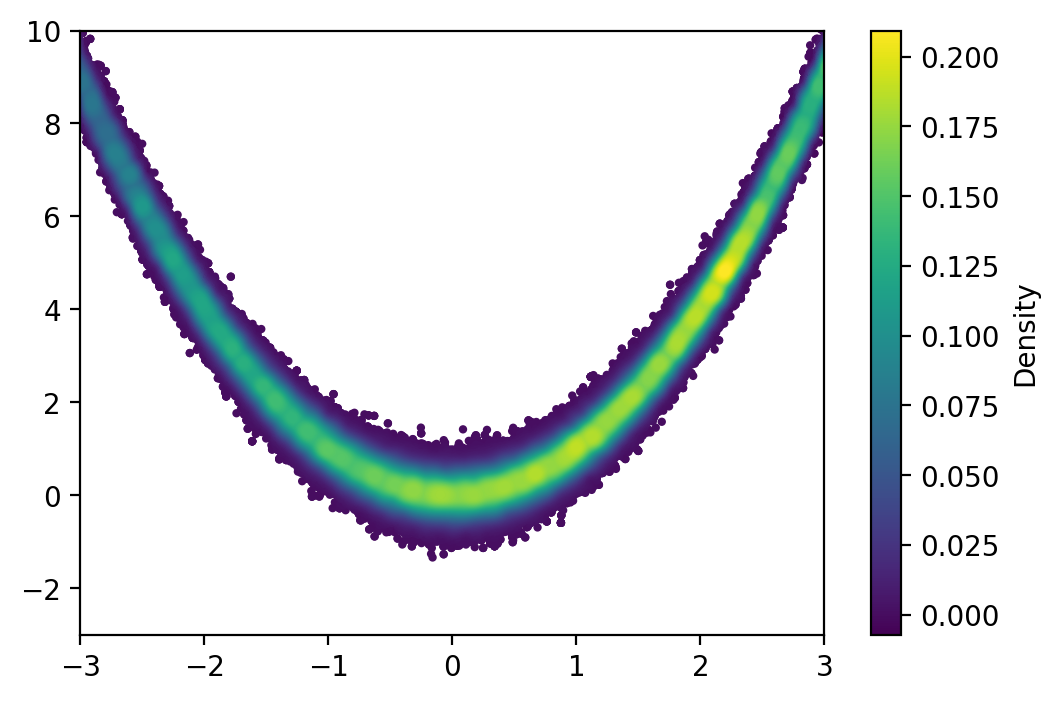

In [7]:
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    else:
        fig = ax.get_figure()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , 
                data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, s=4, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax

fig,ax = plt.subplots()
density_scatter(x[:,0], x[:,1], ax=ax, bins=128)
ax.set_xlim(-3,3)
ax.set_ylim(-3,10);